<a href="https://colab.research.google.com/github/Jcc329/Jessica_DATA606/blob/main/Notebooks/6.Clustering_Analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Data 606 Capstone
## Notebook 6
## Phase 3 Part 1: Clustering
Jessica Conroy

<b> Goal: </b> 
This Notebook aims to perform clustering on the game data to identify the common features of successful games and to tag games with those features for machine learning. This process will take place in three stages
1. Kmeans Elbow Method to determine cluster count<br>
2. Clustering with KMEANS
3. Cluster investigation

<b> Note </b>
- The clustering analysis will focus on game descriptions since these will indicate characteristics of the game as well as the marketing used.

In [1]:
!pip install transformers

In [2]:
!pip install -U sentence-transformers

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision 
import math
from torch.nn.utils.rnn import pack_padded_sequence, pad_packed_sequence
from torchvision import transforms

from torch.utils.data import Dataset, DataLoader

from tqdm.autonotebook import tqdm

from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents

import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow

import pandas as pd

from sklearn.metrics import accuracy_score
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics.pairwise import euclidean_distances
from transformers import BertConfig, BertModel, BertTokenizer

import time

import os

In [4]:
GameData = pd.read_csv('./FinalGameData_postProcessing.csv')

In [5]:
#I will replicate the data prep from the notebook 5.2 and filter out the years prior to 2012
GameData = GameData.fillna('')
GameData['detailed_description.1'] = GameData['detailed_description.1'].astype(str)
GameData['Top Reviews by Upvotes.1'] = GameData['Top Reviews by Upvotes.1'].astype(str)
GameData['tags.1'] = GameData['tags.1'].astype(str)

In [6]:
GameData = GameData[GameData['Release Year']!='']
GameData['Release Year'] = GameData['Release Year'].astype(float)
GameData['Release Year'].value_counts()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


2021.0    3114
2020.0    2447
2018.0    2118
2019.0    2072
2017.0    1679
2016.0    1179
2015.0     783
2014.0     481
2022.0     446
2013.0     210
2012.0     138
2010.0      73
2011.0      69
2009.0      59
2008.0      18
2007.0      14
2006.0       7
2004.0       1
1997.0       1
2000.0       1
Name: Release Year, dtype: int64

In [7]:
GameData = GameData[GameData['Release Year']>=2012]
GameData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14667 entries, 0 to 14951
Data columns (total 55 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   Unnamed: 0                   14667 non-null  int64  
 1   Unnamed: 0.1                 14667 non-null  int64  
 2   type                         14667 non-null  object 
 3   name                         14667 non-null  object 
 4   required_age                 14667 non-null  int64  
 5   is_free                      14667 non-null  bool   
 6   detailed_description         14667 non-null  object 
 7   short_description            14667 non-null  object 
 8   Review Score                 14667 non-null  object 
 9   Review Score Description     14667 non-null  object 
 10  Top Reviews by Upvotes       14667 non-null  object 
 11  appid                        14667 non-null  object 
 12  positive                     14667 non-null  object 
 13  negative        

In [8]:
#Embedding using BERT
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
from sentence_transformers import SentenceTransformer
# sbert_model = SentenceTransformer('bert-base-uncased')

from sentence_transformers import SentenceTransformer
# https://huggingface.co/sentence-transformers/all-mpnet-base-v2

model = SentenceTransformer('sentence-transformers/all-mpnet-base-v2')
description_embeddings = model.encode(list(GameData['detailed_description.1']))
Review_embeddings = model.encode(list(GameData['Top Reviews by Upvotes.1']))
Tag_embeddings = model.encode(list(GameData['tags.1']))

In [9]:
GameData['Description Embeddings'] = list(description_embeddings)
GameData['Review Embeddings'] = list(Review_embeddings)
GameData['Tag Embeddings'] = list(Tag_embeddings)

In [10]:
# from google.colab import files
# GameData.to_csv('Encoded_Game_Data.csv') 
# files.download('Encoded_Game_Data.csv')

In [11]:
# description_embeddings = description_embeddings.to_numpy()

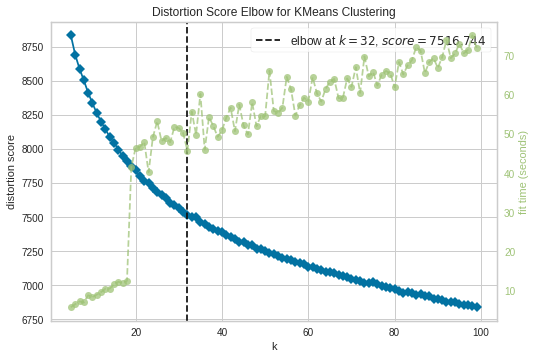

In [12]:
#https://www.scikit-yb.org/en/latest/api/cluster/elbow.html
#https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer

model = KMeans()
visualizer = KElbowVisualizer(model, k=(5,100))

visualizer.fit(description_embeddings)        # Fit the data to the visualizer
visualizer.show()    

In [13]:
# model = KMeans()
# visualizer2 = KElbowVisualizer(model, k=(5,100))

# visualizer2.fit(Review_embeddings)        # Fit the data to the visualizer
# visualizer2.show()    

In [14]:
# model = KMeans()
# visualizer3 = KElbowVisualizer(model, k=(5,100))

# visualizer3.fit(Tag_embeddings)        # Fit the data to the visualizer
# visualizer3.show()    

In [15]:
visualizer.elbow_value_

32

In [16]:
#train models based on number of identified clusters
kmeans1 = KMeans(n_clusters=visualizer.elbow_value_)
kmeans1.fit(description_embeddings)
# assign a cluster to each row
GameData['kmeans_clusters_descriptions'] = kmeans1.predict(description_embeddings)

In [17]:
GameData['kmeans_clusters_descriptions'].unique()

array([18, 11, 12, 13, 23, 24, 31,  0,  5,  2, 14, 21, 17, 22,  9,  7,  6,
       30, 26, 15, 28, 29,  8,  3, 20, 19, 25,  4, 16, 10, 27,  1],
      dtype=int32)

In [18]:
# kmeans2 = KMeans(n_clusters=visualizer2.elbow_value_)
# kmeans2.fit(Review_embeddings)
# # assign a cluster to each row
# GameData['kmeans_clusters_reviews'] = kmeans2.predict(Review_embeddings)

In [19]:
# kmeans3 = KMeans(n_clusters=visualizer3.elbow_value_)
# kmeans3.fit(Tag_embeddings)
# # assign a cluster to each row
# GameData['kmeans_clusters_tags'] = kmeans3.predict(Tag_embeddings)

In [20]:
GameData.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14667 entries, 0 to 14951
Data columns (total 59 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   Unnamed: 0                    14667 non-null  int64  
 1   Unnamed: 0.1                  14667 non-null  int64  
 2   type                          14667 non-null  object 
 3   name                          14667 non-null  object 
 4   required_age                  14667 non-null  int64  
 5   is_free                       14667 non-null  bool   
 6   detailed_description          14667 non-null  object 
 7   short_description             14667 non-null  object 
 8   Review Score                  14667 non-null  object 
 9   Review Score Description      14667 non-null  object 
 10  Top Reviews by Upvotes        14667 non-null  object 
 11  appid                         14667 non-null  object 
 12  positive                      14667 non-null  object 
 13  n

In [21]:
GameData.drop(columns = ['Unnamed: 0', 'Unnamed: 0.1'], inplace = True)
GameData.columns

Index(['type', 'name', 'required_age', 'is_free', 'detailed_description',
       'short_description', 'Review Score', 'Review Score Description',
       'Top Reviews by Upvotes', 'appid', 'positive', 'negative', 'owners',
       'price', 'initialprice', 'discount', 'metacritic', 'Action', 'Casual',
       'Indie', 'Simulation', 'Strategy', 'Early Access', 'Racing', 'RPG',
       'Adventure', 'Education', 'Game Development', 'Massively Multiplayer',
       'Design & Illustration', 'Web Publishing', 'Sexual Content', 'Violent',
       'Gore', 'Sports', 'Animation & Modeling', 'Audio Production',
       'Software Training', 'Utilities', 'Video Production', 'Photo Editing',
       'Nudity', 'mac', 'linux', 'Release Date', 'detailed_description.1',
       'short_description.1', 'Top Reviews by Upvotes.1', 'tags.1',
       'Release Year', 'tags.Lang', 'detailed_description.Lang',
       'Top Reviews by Upvotes.Lang', 'Description Embeddings',
       'Review Embeddings', 'Tag Embeddings', 'km

In [22]:
GameData = GameData[GameData['owners']!='']
GameData['Est. Number of Owners'] = GameData['owners'].str.split(' .. ').str[1]
GameData['Est. Number of Owners'] = GameData['Est. Number of Owners'].str.replace(',', '')
GameData['Est. Number of Owners'] = GameData['Est. Number of Owners'].astype(int)
GameData['Est. Number of Owners'] = GameData['Est. Number of Owners']/2
# GameData.to_csv('Clustered_Game_Data.csv') 
# files.download('Clustered_Game_Data.csv')

# GameData.to_excel('Clustered_Game_Data.xlsx',engine='xlsxwriter') 
# files.download('Clustered_Game_Data.xlsx')

In [54]:
Desc_Agg = pd.DataFrame(GameData.groupby('kmeans_clusters_descriptions').agg([np.mean,np.median, np.std])).reset_index()
Desc_Agg_reviewScores = pd.DataFrame(GameData[['kmeans_clusters_descriptions','Review Score']].value_counts()).reset_index()
Desc_Agg_ownerCounts = pd.DataFrame(GameData[['kmeans_clusters_descriptions','owners']].value_counts()).reset_index()

# Rev_Agg = pd.DataFrame(GameData2.groupby('kmeans_clusters_reviews').agg([np.mean,np.median])).reset_index()
# Rev_Agg_reviewScores = pd.DataFrame(GameData2[['kmeans_clusters_reviews','Review Score']].value_counts()).reset_index()
# Rev_Agg_ownerCounts = pd.DataFrame(GameData2[['kmeans_clusters_reviews','owners']].value_counts()).reset_index()

# Tag_Agg = pd.DataFrame(GameData2.groupby('kmeans_clusters_tags').agg([np.mean,np.median])).reset_index()
# Tag_Agg_reviewScores = pd.DataFrame(GameData2[['kmeans_clusters_tags','Review Score']].value_counts()).reset_index()
# Tag_Agg_ownerCounts = pd.DataFrame(GameData2[['kmeans_clusters_tags','owners']].value_counts()).reset_index()

Desc_Agg.to_csv('./Description Cluster Statistics.csv')
# Rev_Agg.to_csv('./Review Cluster Statistics.csv')
# Tag_Agg.to_csv('./Tag Cluster Statistics.csv')

In [55]:
Desc_Agg.to_csv('./Description Cluster Statistics.csv')

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  """
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_

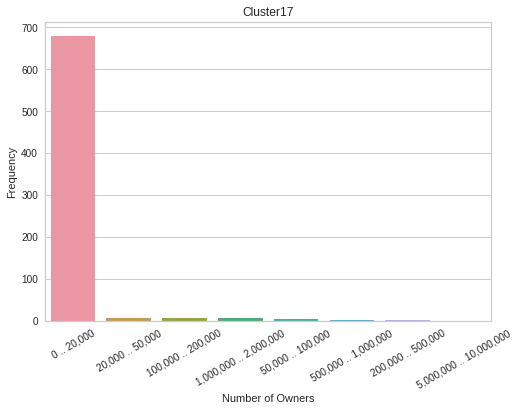

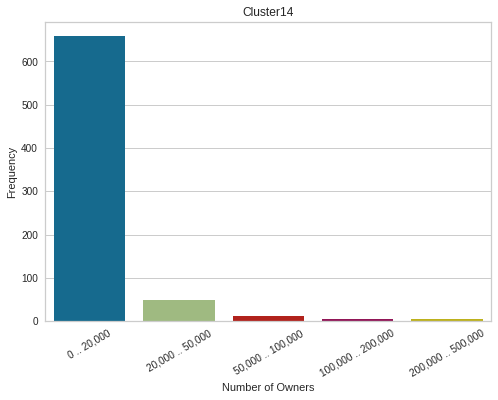

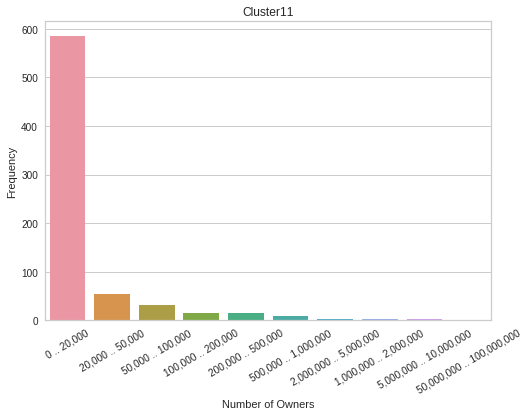

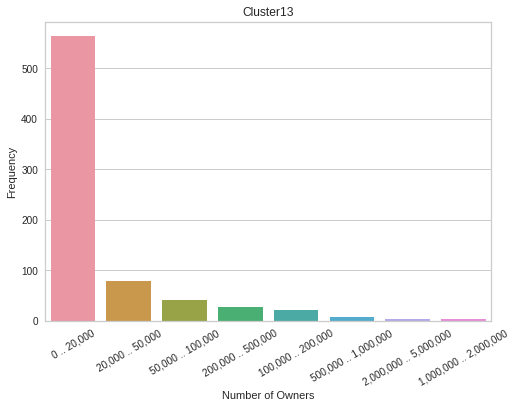

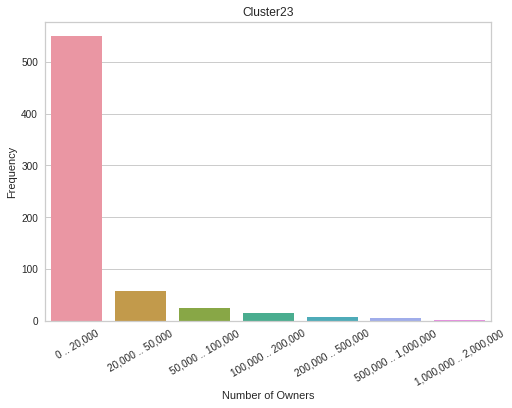

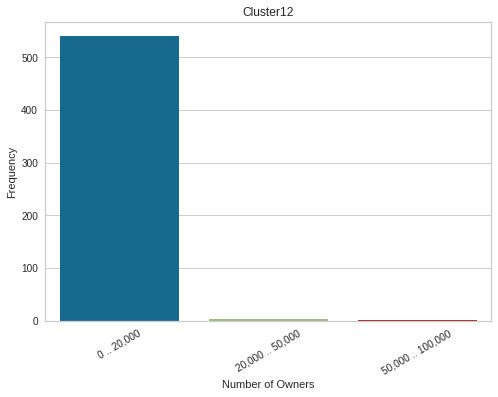

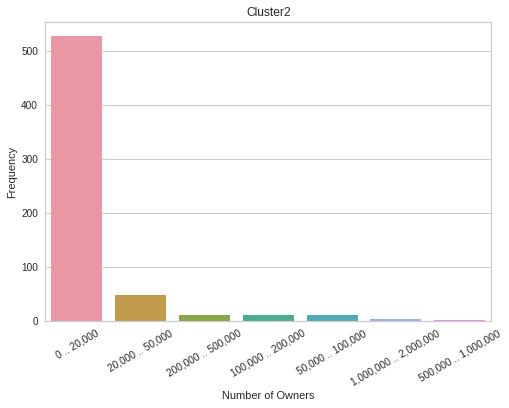

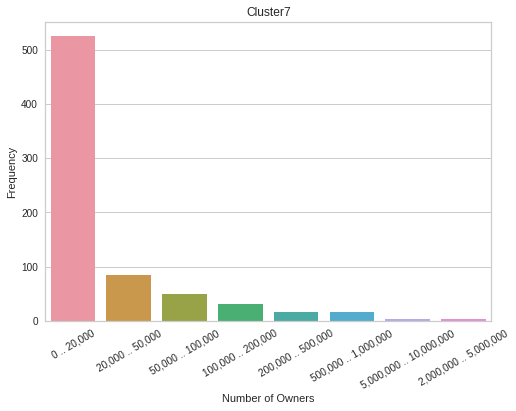

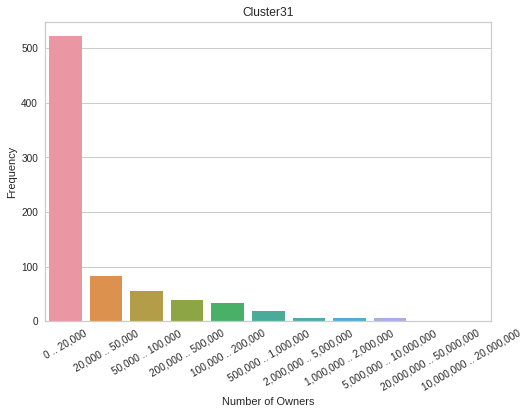

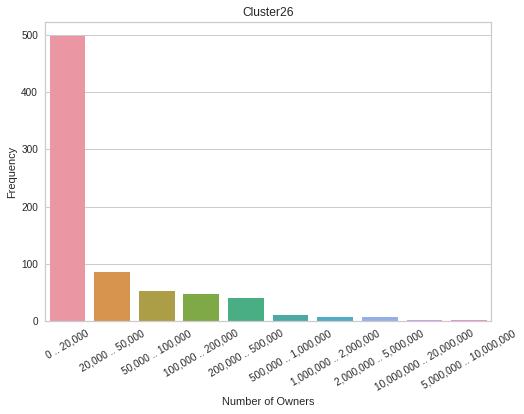

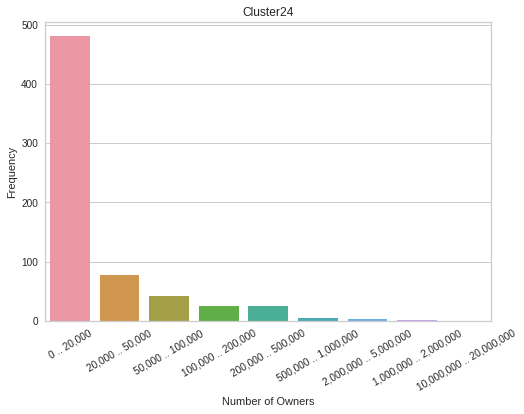

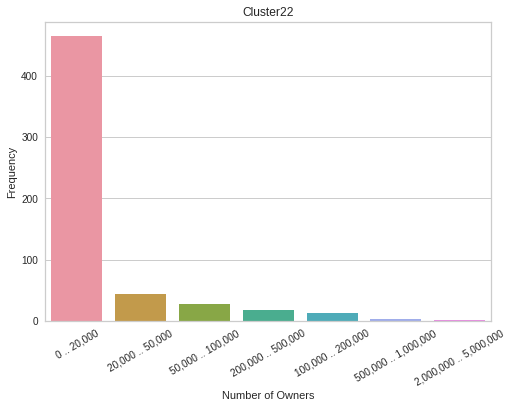

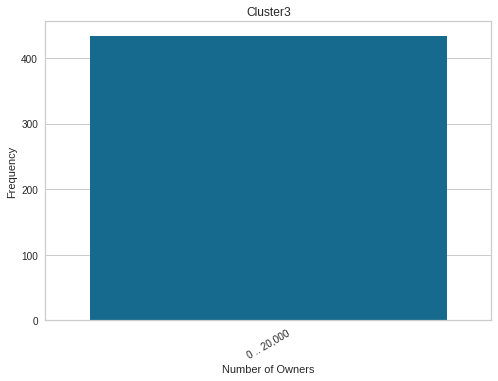

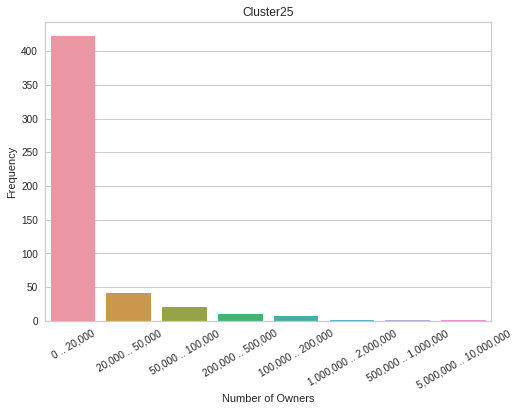

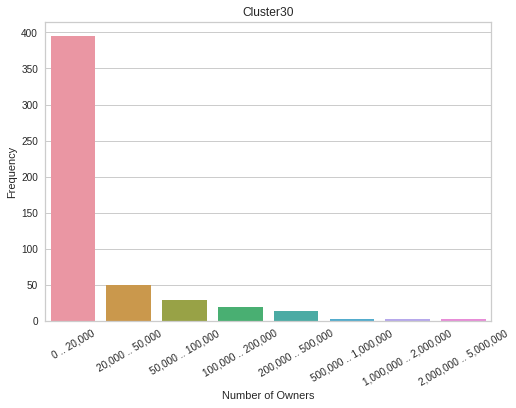

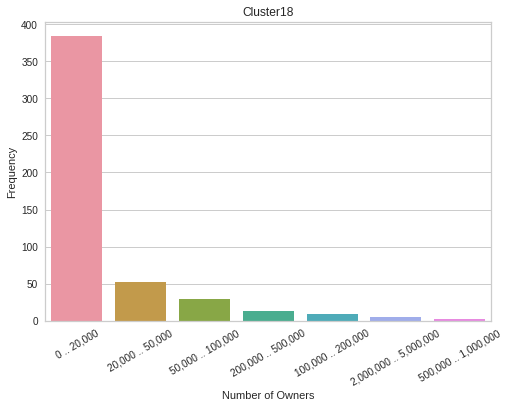

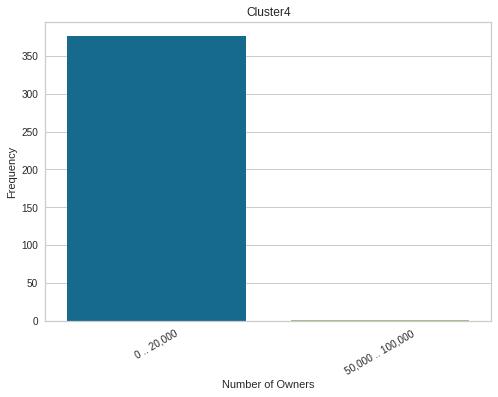

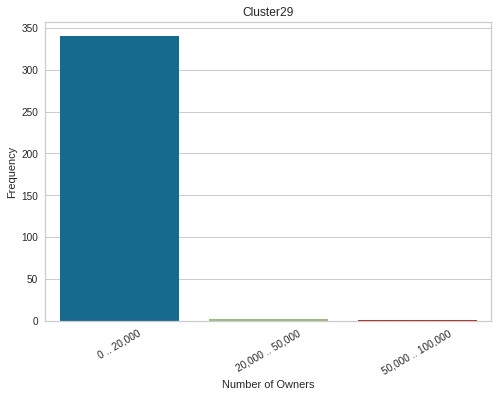

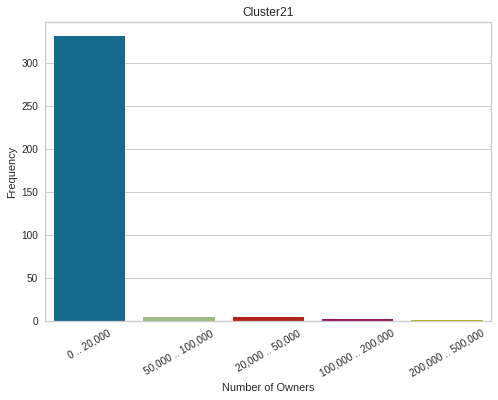

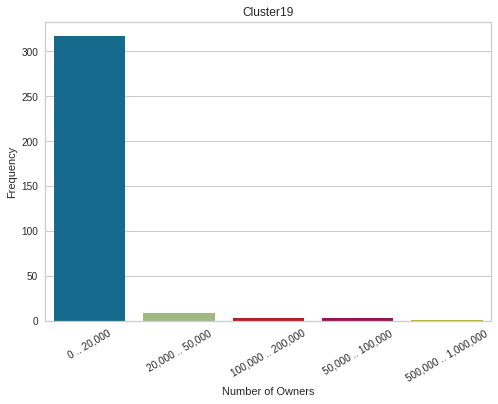

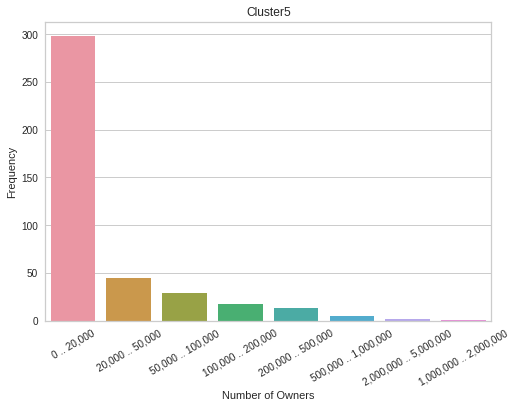

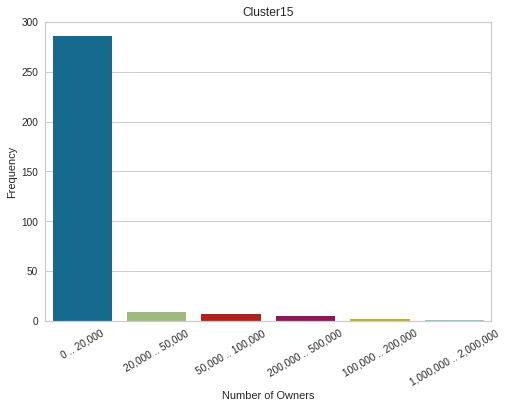

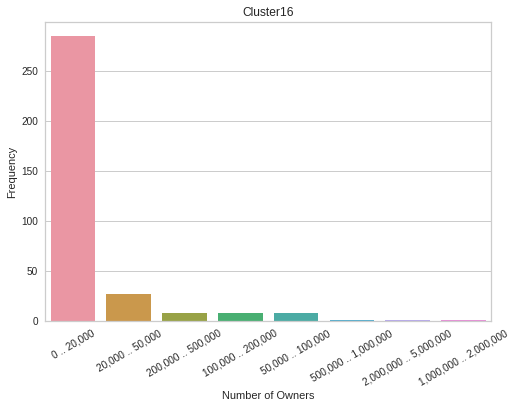

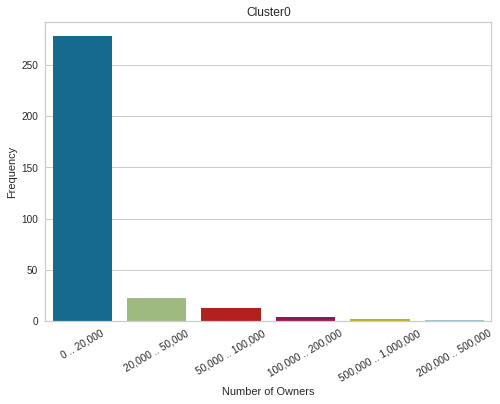

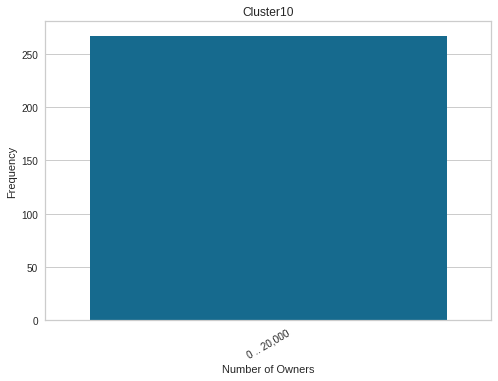

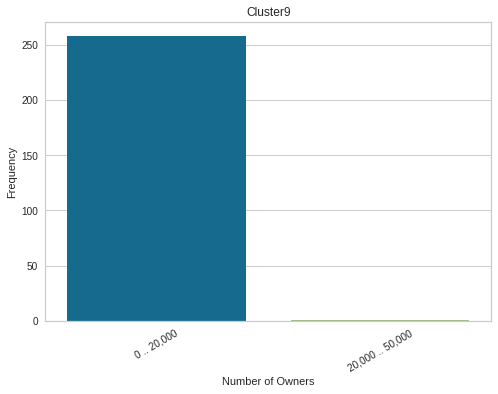

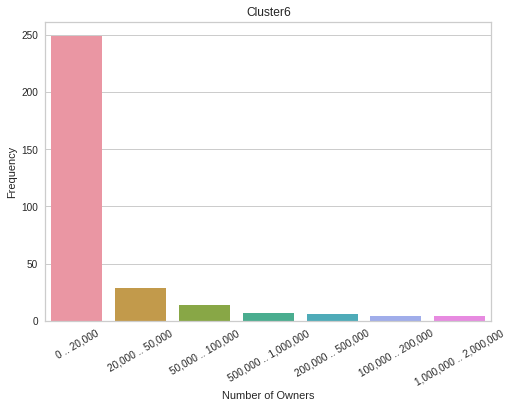

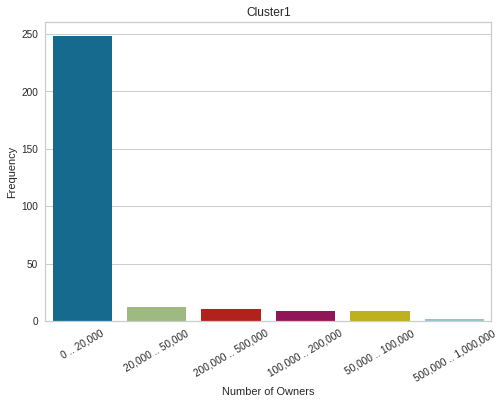

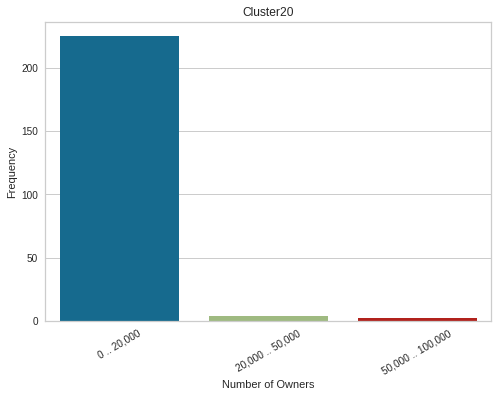

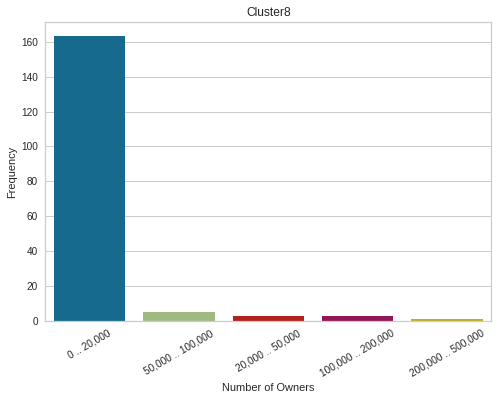

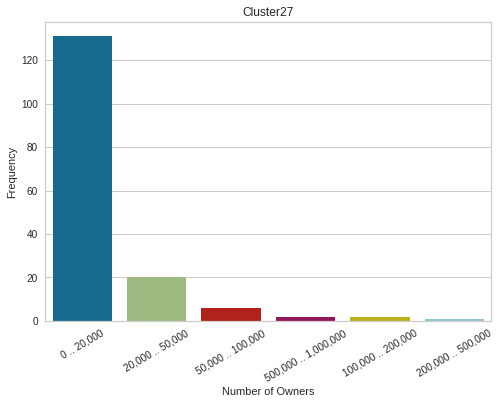

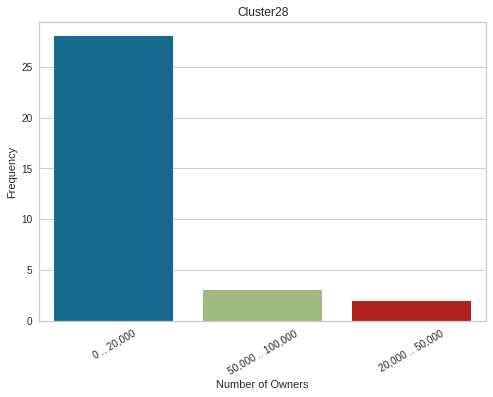

In [24]:
# Desc_Agg_ownerCounts = pd.DataFrame(Desc_Agg_ownerCounts).reset_index()
Desc_Agg_ownerCounts.rename(columns = {'owners': 'Number of Owners', 0:'Frequency'}, inplace = True)
for cluster in Desc_Agg_ownerCounts['kmeans_clusters_descriptions'].unique():
    # print(cluster)
    plt.figure()
    ax = sns.barplot(x="Number of Owners", y='Frequency', data=Desc_Agg_ownerCounts[Desc_Agg_ownerCounts['kmeans_clusters_descriptions']==cluster])
    ax.set_title('Cluster' + str(cluster))
    ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

Text(0.5, 1.0, 'Game Frequency by Description Cluster')

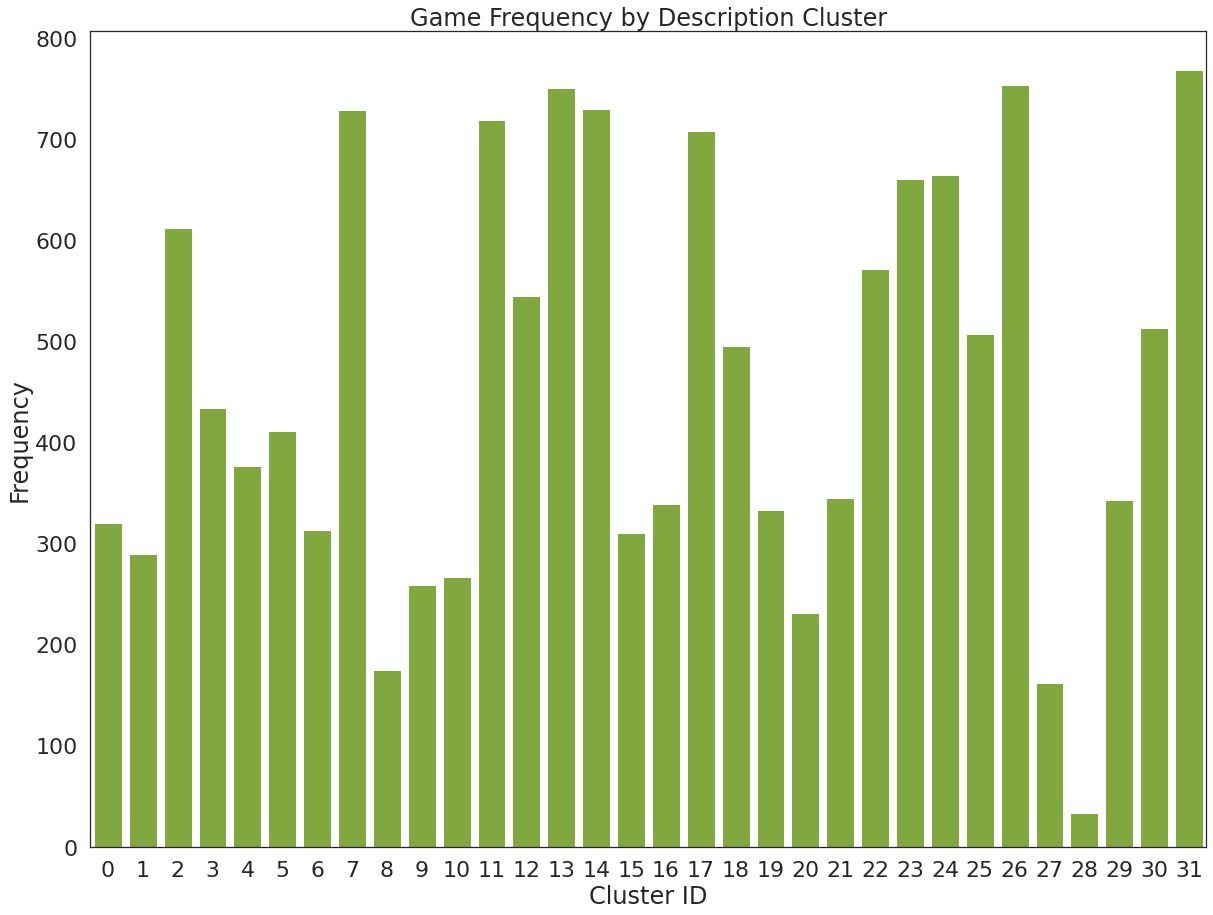

In [25]:
from matplotlib import pyplot as plt
import seaborn as sns

freq = pd.DataFrame(GameData['kmeans_clusters_descriptions'].value_counts()).reset_index()
freq = freq.rename(columns = {'kmeans_clusters_descriptions':'Frequency', 'index':'Cluster ID'})
plt.figure(figsize=(20,15))
sns.set(font_scale = 2)
sns.set_style('white')
ax = sns.barplot(x="Cluster ID", y='Frequency', data=freq, color='#86b92e')
ax.set_title('Game Frequency by Description Cluster')
# ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

In [26]:
# from matplotlib import pyplot as plt
# import seaborn as sns

# freq = pd.DataFrame(GameData['kmeans_clusters_reviews'].value_counts()).reset_index()
# freq = freq.rename(columns = {'kmeans_clusters_reviews':'Frequency', 'index':'Cluster ID'})
# plt.figure(figsize=(20,15))
# sns.set(font_scale = 2)
# sns.set_style('white')
# ax = sns.barplot(x="Cluster ID", y='Frequency', data=freq, color='#86b92e')
# ax.set_title('Game Frequency by Review Cluster')
# # ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

In [27]:
# from matplotlib import pyplot as plt
# import seaborn as sns

# freq = pd.DataFrame(GameData['kmeans_clusters_tags'].value_counts()).reset_index()
# freq = freq.rename(columns = {'kmeans_clusters_tags':'Frequency', 'index':'Cluster ID'})
# plt.figure(figsize=(20,15))
# sns.set(font_scale = 2)
# sns.set_style('white')
# ax = sns.barplot(x="Cluster ID", y='Frequency', data=freq, color='#86b92e')
# ax.set_title('Game Frequency by tag Cluster')
# # ax.set_xticklabels(ax.get_xticklabels(),rotation = 30);

In [28]:
#https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.NMF.html
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF
import numpy as np

def print_NMF_topics(tokenized_texts, max_df=0.95, min_df=1, number_topics=5, number_words_per_topic=10):
  
    text_list=[]

    for token_array in tokenized_texts:
        text_list.append(" ".join(token_array))  # concat tokens for each document to make compatible format for vectorizer.fit_transform()

    vectorizer = TfidfVectorizer(max_df=max_df, min_df=min_df, stop_words='english')
    X = vectorizer.fit_transform(text_list)

    idx_to_word = np.array(vectorizer.get_feature_names())

    # apply NMF
    nmf = NMF(n_components=number_topics, solver="mu")
    W = nmf.fit_transform(X)  # document_topics
    H = nmf.components_       # topic_terms

    for i, topic in enumerate(H):
        print("Topic {}: {}".format(i + 1, ", ".join([str(x) for x in idx_to_word [topic.argsort()[-number_words_per_topic:]]])))
    return H, idx_to_word

# Cluster topic analysis

In [29]:
!pip install gensim==3.8.0

     |████████████████████████████████| 24.2 MB 373 kB/s 
  Attempting uninstall: gensim
    Found existing installation: gensim 3.6.0
    Uninstalling gensim-3.6.0:
      Successfully uninstalled gensim-3.6.0


In [30]:
# Function to create dictionary, bag of words, and tokenized text: https://github.com/Jcc329/Text_Summarization/blob/main/notebooks/Topic_Modeling_YunpengLi.ipynb
# https://radimrehurek.com/gensim/parsing/preprocessing.html
import gensim
print(gensim.__version__)
from gensim.corpora import Dictionary
from gensim.models import TfidfModel, LsiModel
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents
from io import TextIOWrapper

def build_dictionary_preprocess_corpus(text_corpus):
  
  # Preprocess documents 
  tokenized_texts = preprocess_documents(text_corpus)
  
  # Create a dictionary
  dictionary = Dictionary(tokenized_texts)
  
  # Create a list of lists of bow for documents
  bow_corpus = [dictionary.doc2bow(text) for text in tokenized_texts]

  return dictionary, bow_corpus, tokenized_texts

3.6.0


In [31]:
from gensim.models.ldamodel import LdaModel
from gensim.models.coherencemodel import CoherenceModel
from gensim.parsing.preprocessing import preprocess_documents

def compute_coherence_score(tokenized_texts, bow_corpus, dictionary, num_topics, coherence_type, algorithm):
  if algorithm == 'LSI':
    model = LsiModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary)
  else: # algorithm == 'LDA'
    model = LdaModel(corpus = bow_corpus, num_topics = num_topics, id2word = dictionary, passes = 2)

  coherence = CoherenceModel(model=model,
                              corpus=bow_corpus,
                              texts=tokenized_texts,
                              dictionary=dictionary,
                              coherence=coherence_type)
  return coherence.get_coherence()

In [32]:
def generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm, coherence_type='c_v'):
  
  coherence_scores=[]
  min_score=0
  max_score=0

  best_num_topics=1

  for k in range(min_topics, max_topics):
    score = compute_coherence_score(tokenized_texts, bow_corpus, dictionary, k, coherence_type, algorithm)
    coherence_scores.append(score)

    if coherence_type == 'u_mass':
      if score < min_score :
        min_score = score
        best_num_topics = k
    else: # coherence_type == 'c_v'
      if score > max_score:
        max_score = score
        best_num_topics= k

  return coherence_scores, best_num_topics

In [33]:
def print_topics(dictionary, bow_corpus, num_topics, algorithm, num_words=10, friendly_print=True):
  
    if algorithm == 'LSI':
        model = LsiModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary)
    else: # algorithm == 'LDA'
        model = LdaModel(corpus=bow_corpus, num_topics=num_topics, id2word=dictionary, passes=2)

    if friendly_print:
    # Extract terms from results returned by show_topic()
        topicdict = {}
        for topic_number in range(0, num_topics):
            terms = []
        for term, wt in model.show_topic(topic_number, num_words):
            terms.append(term)
        topic = "; ".join([str(x) for x in terms])
        topicdict.update({'Topic ' + str(topic_number): topic})
        print('Topic ' + str(topic_number) + ':', terms)

    else:
        topics = model.print_topics(num_topics, num_words)
        for topic in topics:
            print(topic)
    topicdf = pd.DataFrame.from_dict(topicdict, 'index', columns = ['Topics'])
    return model, topicdf

In [34]:
GameData = GameData.fillna('')

In [35]:
primary_topics = {}
for cluster in Desc_Agg_ownerCounts['kmeans_clusters_descriptions'].unique():
    try:
        temp = GameData[GameData['kmeans_clusters_descriptions']== cluster]
        temp = temp[temp['detailed_description.Lang'].astype(str).str.contains('en')]['detailed_description.1'].values
        # dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        # print('Cluster ' + str(cluster) + ' Topics')
        # H, idx_to_word = print_NMF_topics(tokenized_texts)
        dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        min_topics, max_topics = 5, 100
        coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
        print('The best number of Description topics found by c_v coherence score:', best_num_topics_cv_lda)
        lda_model,topicdf = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)
        for i, topic in enumerate(topicdf['Topics']):
            if i == 0:
                primary_topics.update({cluster:topic})
            else:
                print(i)
    except:
        primary_topics.update({cluster: ''})
        print('Could not find topics for cluster ' + str(cluster))

topics = pd.DataFrame.from_dict(primary_topics, orient = 'index', columns = ['Description Topics']).reset_index()
topics = topics.rename(columns = {'index':'Cluster'})
GameData = GameData.merge(topics, left_on = 'kmeans_clusters_descriptions', right_on = 'Cluster')

/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


The best number of Description topics found by c_v coherence score: 72
Topic 71: ['new', 'pack', 'charact', 'support', 'crown', 'weapon', 'stori', 'dlc', 'return', 'salamand', 'plagu', 'skin', 'come', 'zombi', 'girl']
The best number of Description topics found by c_v coherence score: 7
Topic 6: ['level', 'puzzl', 'game', 'color', 'us', 'complet', 'object', 'door', 'time', 'platform', 'egg', 'enemi', 'simpl', 'open', 'set']
The best number of Description topics found by c_v coherence score: 20
Topic 19: ['level', 'weapon', 'surviv', 'game', 'player', 'enemi', 'zombi', 'wave', 'kill', 'wai', 'try', 'differ', 'shooter', 'demon', 'possibl']
The best number of Description topics found by c_v coherence score: 6
Topic 5: ['game', 'player', 'world', 'stori', 'challeng', 'charact', 'level', 'adventur', 'plai', 'enemi', 'gameplai', 'new', 'uniqu', 'like', 'mode']
The best number of Description topics found by c_v coherence score: 6
Topic 5: ['game', 'attackwav', 'girl', 'damagewav', 'love', 'us

In [36]:
primary_topics = {}
for cluster in Desc_Agg_ownerCounts['kmeans_clusters_descriptions'].unique():
    try:
        temp = GameData[GameData['kmeans_clusters_descriptions']== cluster]
        temp = temp[temp['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes'].values
        # dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        # print('Cluster ' + str(cluster) + ' Topics')
        # H, idx_to_word = print_NMF_topics(tokenized_texts)
        dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        min_topics, max_topics = 5, 100
        coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
        print('The best number of Description topics found by c_v coherence score:', best_num_topics_cv_lda)
        lda_model,topicdf = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)
        for i, topic in enumerate(topicdf['Topics']):
            if i == 0:
                primary_topics.update({cluster:topic})
            else:
                print(i)
    except:
        primary_topics.update({cluster: ''})
        print('Could not find topics for cluster ' + str(cluster))

topics = pd.DataFrame.from_dict(primary_topics, orient = 'index', columns = ['Review Topics']).reset_index()
topics = topics.rename(columns = {'index':'Cluster'})
GameData = GameData.merge(topics, left_on = 'kmeans_clusters_descriptions', right_on = 'Cluster')

Could not find topics for cluster 11


/usr/local/lib/python3.7/dist-packages/gensim/models/ldamodel.py:1023: RuntimeWarning: divide by zero encountered in log
  def do_mstep(self, rho, other, extra_pass=False):


The best number of Description topics found by c_v coherence score: 17
Topic 16: ['movement', 'glitchi', 'horribl', 'unrespons', 'clunki', 'game', 'plai', 'fun', 'level', 'control', 'like', 'time', 'jump', 'feel', 'look']
The best number of Description topics found by c_v coherence score: 92
Topic 91: ['slide', 'game', 'water', 'url', 'like', 'com', 'oper', 'puzzl', 'cross', 'stand', 'leg', 'straight', 'button', 'steamcommun', 'nut']
The best number of Description topics found by c_v coherence score: 95
Topic 94: ['stage', 'dlc', 'pretti', 'charact', 'kami', 'lap', 'custom', 'love', 'zidan', 'room', 'rank', 'bronc', 'current', 'protein', 'need']
The best number of Description topics found by c_v coherence score: 63
Topic 62: ['game', 'plai', 'final', 'like', 'fun', 'look', 'easi', 'board', 'stori', 'wai', 'time', 'script', 'ruin', 'good', 'version']
The best number of Description topics found by c_v coherence score: 63
Topic 62: ['game', 'like', 'plai', 'time', 'want', 'stori', 'enemi'

In [37]:
primary_topics = {}
for cluster in Desc_Agg_ownerCounts['kmeans_clusters_descriptions'].unique():
    try:
        temp = GameData[GameData['kmeans_clusters_descriptions']== cluster]
        temp = temp[temp['tags.Lang'].astype(str).str.contains('en')]['Tags.1'].values
        # dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        # print('Cluster ' + str(cluster) + ' Topics')
        # H, idx_to_word = print_NMF_topics(tokenized_texts)
        dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        min_topics, max_topics = 5, 100
        coherence_scores_cv_lda, best_num_topics_cv_lda = generate_coherence_scores(min_topics, max_topics, tokenized_texts, bow_corpus, dictionary, algorithm='LDA', coherence_type='c_v')
        print('The best number of Description topics found by c_v coherence score:', best_num_topics_cv_lda)
        lda_model,topicdf3 = print_topics(dictionary, bow_corpus, best_num_topics_cv_lda, algorithm='LDA', num_words=15, friendly_print=True)
        for i, topic in enumerate(topicdf['Topics']):
            if i == 0:
                primary_topics.update({cluster:topic})
            else:
                print(i)
    except:
        primary_topics.update({cluster: ''})
        print('Could not find topics for cluster ' + str(cluster))

topics = pd.DataFrame.from_dict(primary_topics, orient = 'index', columns = ['Tag Topics']).reset_index()
topics = topics.rename(columns = {'index':'Cluster'})
GameData = GameData.merge(topics, left_on = 'kmeans_clusters_descriptions', right_on = 'Cluster')

Could not find topics for cluster 17
Could not find topics for cluster 14
Could not find topics for cluster 11
Could not find topics for cluster 13
Could not find topics for cluster 23
Could not find topics for cluster 12
Could not find topics for cluster 2
Could not find topics for cluster 7
Could not find topics for cluster 31
Could not find topics for cluster 26
Could not find topics for cluster 24
Could not find topics for cluster 22
Could not find topics for cluster 3
Could not find topics for cluster 25
Could not find topics for cluster 30
Could not find topics for cluster 18
Could not find topics for cluster 4
Could not find topics for cluster 29
Could not find topics for cluster 21
Could not find topics for cluster 19
Could not find topics for cluster 5
Could not find topics for cluster 15
Could not find topics for cluster 16
Could not find topics for cluster 0
Could not find topics for cluster 10
Could not find topics for cluster 9
Could not find topics for cluster 6
Could not

In [38]:
# primary_topics = {}
# for cluster in Desc_Agg_ownerCounts['kmeans_clusters_descriptions'].unique():
#     try:
#         temp = GameData[GameData['kmeans_clusters_descriptions']== cluster]
#         temp = temp[temp['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes'].values
#         dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
#         print('Cluster ' + str(cluster) + ' Topics')
#         H, idx_to_word = print_NMF_topics(tokenized_texts)
#         for i, topic in enumerate(H):
#             if i == 0:
#                 primary_topics.update({cluster:"; ".join([str(x) for x in idx_to_word [topic.argsort()[-10:]]])})
#             else:
#                 print(i)
#     except:
#         primary_topics.update({cluster: ''})
#         print('Could not find topics for cluster ' + str(cluster))
# topics = pd.DataFrame.from_dict(primary_topics, orient = 'index', columns = ['Review Topics']).reset_index()
# topics = topics.rename(columns = {'index':'Cluster'})
# GameData = GameData.merge(topics, left_on = 'kmeans_clusters_descriptions', right_on = 'Cluster')

In [49]:
primary_topics = {}
for cluster in Desc_Agg_ownerCounts['kmeans_clusters_descriptions'].unique():
    try:
        temp = GameData[GameData['kmeans_clusters_descriptions']== cluster]
        temp = temp[temp['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values
        dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
        print('Cluster ' + str(cluster) + ' Topics')
        H, idx_to_word = print_NMF_topics(tokenized_texts)
        for i, topic in enumerate(H):
            if i == 0:
                primary_topics.update({cluster:"; ".join([str(x) for x in idx_to_word [topic.argsort()[-10:]]])})
            else:
                print(i)
    except:
        primary_topics.update({cluster: ''})
        print('Could not find topics for cluster ' + str(cluster))
topics = pd.DataFrame.from_dict(primary_topics, orient = 'index', columns = ['Tag Topics']).reset_index()
topics = topics.rename(columns = {'index':'Cluster'})
GameData = GameData.merge(topics, left_on = 'kmeans_clusters_descriptions', right_on = 'Cluster')

Cluster 17 Topics
Topic 1: race, anim, nuditi, fight, fp, gore, violent, sport, indi, action
Topic 2: nuditi, race, grand, dinosaur, free, plai, simul, casual, indi, strategi
Topic 3: race, nuditi, sport, violent, simul, rpg, multiplay, plai, free, massiv
Topic 4: charact, fantasi, jrpg, heist, stealth, dog, coop, anim, indi, rpg
Topic 5: fp, shooter, nuditi, world, open, indi, casual, gore, violent, adventur
1
2
3
4
Cluster 14 Topics


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Topic 1: physic, educ, plai, free, relax, minimalist, singleplay, puzzl, indi, casual
Topic 2: famili, friendli, logic, cute, color, puzzl, minimalist, relax, singleplay, platform
Topic 3: free, plai, puzzleplatform, earli, access, rpg, platform, indi, adventur, action
Topic 4: manag, race, firstperson, strategi, walk, explor, sport, earli, access, simul
Topic 5: friendli, famili, space, logic, relax, game, board, turnbas, puzzl, strategi
1
2
3
4
Cluster 11 Topics
Topic 1: plai, tank, sport, zombi, arcad, shoot, adventur, casual, action, indi
Topic 2: plai, arcad, firstperson, fp, topdown, local, coop, singleplay, multiplay, shooter
Topic 3: blood, simul, nuditi, rpg, zombi, fp, action, adventur, gore, violent
Topic 4: physic, custom, charact, firstperson, massiv, fp, multiplay, simul, access, earli
Topic 5: singleplay, rt, puzzl, platform, tactic, turnbas, rpg, adventur, simul, strategi
1
2
3
4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Cluster 13 Topics
Topic 1: arcad, retro, earli, access, puzzl, adventur, platform, casual, action, indi
Topic 2: cute, precis, color, difficult, scroller, retro, singleplay, graphic, pixel, platform
Topic 3: relax, atmospher, free, plai, singleplay, race, puzzl, strategi, casual, simul
Topic 4: great, soundtrack, rich, stori, fantasi, turnbas, indi, action, adventur, rpg
Topic 5: retro, pvp, sport, shoot, action, arcad, player, coop, multiplay, local
1
2
3
4
Cluster 23 Topics


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Topic 1: date, sim, cute, romanc, nuditi, sexual, content, anim, visual, novel
Topic 2: anim, visual, novel, nuditi, rpg, adventur, strategi, simul, casual, indi
Topic 3: cartoon, anim, short, horror, faith, adventur, visual, novel, plai, free
Topic 4: click, atmospher, end, multipl, singleplay, choic, matter, adventur, stori, rich
Topic 5: horror, fantasi, graphic, pixel, platform, femal, protagonist, rpgmaker, rpg, action
1
2
3
4
Cluster 12 Topics
Topic 1: rpg, multiplay, firstperson, shooter, massiv, gore, nuditi, violent, adventur, action
Topic 2: puzzl, rpg, gore, singleplay, clicker, strategi, nuditi, casual, adventur, indi
Topic 3: cinemat, explor, rpgmaker, femal, protagonist, stori, rich, anim, strategi, rpg
Topic 4: arcad, sandbox, anim, race, multiplay, massiv, sport, indi, simul, strategi
Topic 5: collector, creatur, mmorpg, rpg, clicker, strategi, multiplay, massiv, free, plai
1
2
3
4
Cluster 2 Topics
Topic 1: jrpg, anim, turnbas, free, plai, casual, rpgmaker, adventur, in

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Cluster 7 Topics
Topic 1: plai, multiplay, platform, rpg, earli, access, casual, adventur, action, indi
Topic 2: build, farm, builder, citi, resourc, sim, casual, manag, strategi, simul
Topic 3: earli, coop, firstperson, horror, sandbox, multiplay, craft, open, world, surviv
Topic 4: stori, rich, singleplay, funni, puzzl, pixel, graphic, coop, platform, local
Topic 5: game, dungeon, roguelik, combat, fantasi, tactic, rpgmaker, strategi, turnbas, rpg
1
2
3
4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Cluster 31 Topics
Topic 1: difficult, race, arcad, sport, simul, platform, adventur, casual, indi, action
Topic 2: stick, retro, singleplay, scifi, hell, shoot, bullet, arcad, topdown, shooter
Topic 3: open, adventur, zombi, fp, surviv, horror, gore, violent, access, earli
Topic 4: scifi, game, rt, simul, rpg, defens, tower, tactic, turnbas, strategi
Topic 5: onlin, massiv, free, plai, fight, competit, player, coop, multiplay, local
1
2
3
4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Cluster 26 Topics
Topic 1: slash, hack, fantasi, platform, graphic, pixel, indi, adventur, rpg, action
Topic 2: roguelik, game, card, partybas, fantasi, combat, rpg, tactic, strategi, turnbas
Topic 3: choos, object, hidden, rpgmaker, textbas, strategi, simul, adventur, indi, casual
Topic 4: femal, protagonist, great, soundtrack, puzzl, dark, atmospher, singleplay, stori, rich
Topic 5: access, simul, massiv, surviv, horror, open, world, plai, free, multiplay
1
2
3
4


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,


Cluster 24 Topics
Topic 1: singleplay, explor, indi, dark, atmospher, simul, firstperson, surviv, psycholog, horror
Topic 2: femal, mysteri, detect, puzzl, adventur, click, point, casual, object, hidden
Topic 3: rpgmaker, textbas, access, earli, rpg, casual, horror, action, adventur, indi
Topic 4: rpg, adventur, great, soundtrack, novel, visual, stori, rich, protagonist, femal
Topic 5: earli, access, rpg, action, content, sexual, nuditi, horror, gore, violent
1
2
3
4
Cluster 22 Topics


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Topic 1: famili, friendli, rpg, match, action, singleplay, puzzl, adventur, casual, indi
Topic 2: cute, relax, color, singleplay, hidden, object, point, click, friendli, famili
Topic 3: life, casual, plai, free, sim, horror, manag, sport, strategi, simul
Topic 4: soundtrack, funni, cute, multiplay, plai, free, pixel, graphic, platform, action
Topic 5: plai, match, solitair, turnbas, sport, board, casual, card, game, strategi
1
2
3
4
Cluster 3 Topics
Topic 1: rhythm, anim, race, action, indi, simul, sport, casual, free, plai
Topic 2: softwar, anim, rhythm, content, sexual, violent, gore, rpg, nuditi, action
Topic 3: rpgmaker, access, earli, gore, nuditi, violent, adventur, indi, strategi, rpg
Topic 4: great, singleplay, soundtrack, horror, nuditi, content, sexual, casual, indi, adventur
Topic 5: drama, multiplay, massiv, race, strategi, earli, access, action, indi, simul
1
2
3
4
Cluster 25 Topics
Topic 1: magic, horror, roguelik, gore, shooter, violent, rpg, adventur, indi, action
Topic

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Cluster 30 Topics
Topic 1: violent, access, earli, simul, strategi, casual, adventur, action, rpg, indi
Topic 2: deckbuild, roguelik, game, singleplay, card, fantasi, combat, strategi, tactic, turnbas
Topic 3: hack, slash, arcad, fantasi, singleplay, platform, action, multiplay, coop, local
Topic 4: trade, strategi, earli, access, game, multiplay, card, massiv, plai, free
Topic 5: grand, pve, war, minimalist, singleplay, basebuild, rt, defens, tower, strategi
1
2
3
4
Cluster 18 Topics
Topic 1: sport, rpg, violent, access, earli, casual, strategi, adventur, indi, action
Topic 2: rpg, open, world, access, earli, scifi, singleplay, adventur, sim, space
Topic 3: plai, free, manag, multiplay, tactic, scifi, rt, space, turnbas, strategi
Topic 4: attack, space, casual, retro, hell, bullet, shoot, arcad, topdown, shooter
Topic 5: transport, editor, level, puzzl, walk, sim, free, plai, casual, simul
1
2
3
4
Cluster 4 Topics


/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Topic 1: multiplay, massiv, plai, free, fight, gore, violent, sport, adventur, action
Topic 2: rpg, content, sexual, casual, massiv, multiplay, nuditi, simul, indi, adventur
Topic 3: design, web, content, sexual, violent, gore, nuditi, adventur, strategi, rpg
Topic 4: board, turnbas, cute, game, anim, massiv, multiplay, strategi, indi, casual
Topic 5: cartooni, plai, free, sport, casual, gore, violent, nuditi, content, sexual
1
2
3
4
Cluster 29 Topics
Topic 1: multiplay, gore, great, sport, adventur, horror, rpg, soundtrack, indi, action
Topic 2: massiv, free, plai, gore, violent, casual, simul, indi, rpg, adventur
Topic 3: rhythm, meme, famili, action, casual, massiv, music, rpg, simul, strategi
Topic 4: funni, femal, protagonist, nuditi, singleplay, great, multiplay, music, indi, casual
Topic 5: anim, beat, retro, arcad, gore, race, sport, violent, music, indi
1
2
3
4
Cluster 21 Topics
Topic 1: softwar, earli, access, game, develop, illustr, design, util, model, anim
Topic 2: content

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Cluster 5 Topics
Topic 1: singleplay, economi, classic, histor, manag, grand, casual, indi, simul, strategi
Topic 2: plai, singleplay, violent, earli, access, rpg, adventur, casual, action, indi
Topic 3: economi, sandbox, basebuild, singleplay, resourc, build, citi, builder, sim, manag
Topic 4: earli, access, combat, multiplay, game, fantasi, tactic, rpg, strategi, turnbas
Topic 5: horror, visual, novel, end, multipl, adventur, matter, choic, stori, rich
1
2
3
4
Cluster 15 Topics
Topic 1: strategi, investig, race, walk, singleplay, fish, indi, flight, sport, simul
Topic 2: build, friendli, famili, puzzl, manag, adventur, singleplay, strategi, casual, indi
Topic 3: access, realist, sport, flight, singleplay, massiv, multiplay, adventur, plai, free
Topic 4: strategi, comedi, horror, multiplay, indi, massiv, race, rpg, sport, action
Topic 5: model, publish, web, time, anim, nuditi, train, softwar, educ, util
1
2
3
4
Cluster 16 Topics
Topic 1: action, footbal, basketbal, race, manag, casua

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Cluster 0 Topics
Topic 1: music, strategi, race, singleplay, access, earli, sport, indi, casual, simul
Topic 2: asymmetr, control, rhythm, massiv, educ, multiplay, softwar, util, earli, access
Topic 3: surviv, race, singleplay, horror, puzzl, strategi, rpg, indi, action, adventur
Topic 4: web, audio, design, illustr, softwar, util, anim, model, video, product
Topic 5: psycholog, rhythm, action, rpg, massiv, adventur, horror, multiplay, plai, free
1
2
3
4
Cluster 10 Topics
Could not find topics for cluster 10
Cluster 9 Topics
Could not find topics for cluster 9
Cluster 6 Topics
Topic 1: game, board, wargam, rpg, tactic, grand, histor, indi, turnbas, strategi
Topic 2: action, fp, coop, multiplay, militari, tactic, shooter, singleplay, world, war
Topic 3: famili, fantasi, world, autom, looter, foreign, free, plai, flight, simul
Topic 4: massiv, arcad, music, shooter, rpg, violent, adventur, casual, indi, action
Topic 5: rpg, turnbas, earli, access, adventur, indi, multiplay, massiv, free,

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

Topic 1: automobil, strategi, cycl, indi, plai, free, motorbik, race, simul, sport
Topic 2: multiplay, singleplay, earli, access, offroad, arcad, indi, drive, automobil, sim
Topic 3: futurist, time, runner, graphic, pixel, topdown, combat, singleplay, action, race
Topic 4: build, sandbox, difficult, simul, strategi, sport, adventur, casual, action, indi
Topic 5: screen, motorbik, open, world, singleplay, action, local, coop, massiv, multiplay
1
2
3
4
Cluster 20 Topics
Topic 1: train, physic, sandbox, realist, friendli, famili, atmospher, trackir, open, world
Topic 2: fish, adventur, action, puzzl, actionadventur, board, game, strategi, casual, indi
Topic 3: famili, indi, coop, physic, race, action, puzzl, actionadventur, adventur, train
Topic 4: flight, singleplay, drive, builder, level, editor, citi, moddabl, build, casual
Topic 5: paus, histor, resourc, grand, multiplay, transport, economi, realtim, manag, strategi
1
2
3
4
Cluster 8 Topics
Topic 1: level, editor, adventur, simul, act

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and n_features, will be changed from 'nndsvd' to 'nndsvda' in 1.1 (renaming of 0.26).
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/decomposition/_nmf.py:294: FutureWarning: The 'init' value, when 'init=None' and n_components is less than n_samples and

In [40]:
# for cluster in Rev_Agg_ownerCounts['kmeans_clusters_reviews'].unique():
#     try:
#         temp = GameData[GameData['kmeans_clusters_reviews']== cluster]
#         temp = temp[temp['Top Reviews by Upvotes.Lang'].astype(str).str.contains('en')]['Top Reviews by Upvotes'].values
#         dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
#         print('Cluster ' + str(cluster) + ' Topics')
#         print_NMF_topics(tokenized_texts)
#     except:
#         print('Could not find topics for cluster ' + str(cluster))

In [41]:
# for cluster in Tag_Agg_ownerCounts['kmeans_clusters_tags'].unique():
#     try:
#         temp = GameData[GameData['kmeans_clusters_tags']== cluster]
#         temp = temp[temp['tags.Lang'].astype(str).str.contains('en')]['tags.1'].values
#         dictionary, bow_corpus, tokenized_texts = build_dictionary_preprocess_corpus(temp)
#         print('Cluster ' + str(cluster) + ' Topics')
#         print_NMF_topics(tokenized_texts)
#     except:
#         print('Could not find topics for cluster ' + str(cluster))

In [42]:
GameData.head().T

,0,1,2,3,4
type,game,game,game,game,game
name,White Eyes,Pixel Galaxy,Man in gravity,Starship EVO,Atom Universe
required_age,0,0,0,0,0
is_free,False,False,False,False,True
detailed_description,The universe implodes and interstellar nomads ...,<h1>ALL Serenity Forge games on Sale!</h1><p>W...,<strong>Man in gravity</strong> - a runner in ...,PLEASE NOTE: Starship EVO is still being worke...,Atom Universe is a Free-to-Play social Virtual...
...,...,...,...,...,...
Description Topics,game; space; ship; planet; new; time; differ; ...,game; space; ship; planet; new; time; differ; ...,game; space; ship; planet; new; time; differ; ...,game; space; ship; planet; new; time; differ; ...,game; space; ship; planet; new; time; differ; ...
Cluster_y,18,18,18,18,18
Review Topics,game; dlc; stori; cost; plai; new; campaign; f...,game; dlc; stori; cost; plai; new; campaign; f...,game; dlc; stori; cost; plai; new; campaign; f...,game; dlc; stori; cost; plai; new; campaign; f...,game; dlc; stori; cost; plai; new; campaign; f...
Cluster,18,18,18,18,18


In [50]:
from google.colab import files
GameData.to_csv('Clustered_Game_Data_wtags.csv') 
# files.download('Clustered_Game_Data.csv')


In [51]:
!pip install xlsxwriter

In [52]:
GameData.to_excel('Clustered_Game_Data_wtags.xlsx') 
# files.download('Clustered_Game_Data.xlsx')

/usr/local/lib/python3.7/dist-packages/xlsxwriter/worksheet.py:1172: UserWarning: Ignoring URL 'https://youtu.be/5wX3j0I9BuQ

Devil%20Fight%20is%20basically%20an%20unfinished%20Unity%20asset%20flip.%20You%20spawn%20in%20a%20random%20city%20with%20random%20hordes%20of%20the%20same%20monsters%20charging%20at%20you,%20a%20random%20demon%20with%20a%20whip.%20There%20is%20no%20music,%20and%20the%20only%20sound%20effect%20comes%20from%20said%20monsters%20hitting%20your%20demon.%20Most%20of%20the%20hits%20don't%20even%20connect%20from%20them,%20as%20well%20as%20you.%20Some%20monsters%20even%20spawn%20stuck%20sticking%20out%20of%20buildings.

Don't%20waste%20your%20$1%20(USD)%20or%20currency%20equivilent.%20Not%20even%20if%20it%20goes%20on%20sale.%20Digital%20Homicide%20games%20had%20more%20depth%20than%20this%20cash%20grab.Yet%20another%20trash%20asset%20flip%20from%20a%20developer%20flipping%20out%20the%20same%20trash%20game%20with%20different%20maps%20and%20assets%20and%20using%20many%20dif